<a href="https://colab.research.google.com/github/Abdulla-asim/DeepLearning/blob/main/Notebooks/06_PyTorch_transfer_learning_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercise

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our own model compared to truth labels.

In [ ]:
# import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it dosen't work
try:
  from torchinfo import summary
except:
  print(f"[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

# Try to import the going_modular directory, downlaod it from GitHub if it dosen't work
try:
  from going_modular import data_setup, engine
except:
  # get the going_modular scripts
  print(f"[INFO] Couldn't find the going modular scripts...downloading them")
  !git clone https://github.com/Abdulla-asim/DeepLearning
  !mv DeepLearning/going_modular .
  !rm -rf DeepLearning
  from going_modular import data_setup, engine

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1.1 Get Data

In [ ]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder does not exist, create it
if image_path.is_dir():
  print(f"{image_path} directory exists")
else:
  image_path.mkdir(parents=True, exist_ok=True)

  # Download the pizza, stea, and sushi images
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print(f"Downloading pizza, steak, sushi data...")
    f.write(request.content)

  # Unzip the data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as f:
    print(f"Unzipping pizza, steak, sushi data...")
    f.extractall(image_path)

  # Remove the zip file
  os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
test_dir = image_path / "test"
train_dir = image_path / "train"

data/pizza_steak_sushi directory exists


### 1.2 Prepare the Data


In [ ]:
# Create a transform pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e10cdf3cf90>,
 ['pizza', 'steak', 'sushi'])

### 1.3 Get and prepare pretrained model

In [ ]:
# Setup the model with pretrained weights and send it to target device
#model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_0 = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [ ]:
# Freeze all the layers in the "features" section of model
for param in model_0.features.parameters():
  param.requires_grad = False

In [ ]:
# SEt manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)
).to(device)

### 1.3 Train Model

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time  = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                               train_dataloader=train_dataloader,
                               test_dataloader=test_dataloader,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=5,
                               device=device)

# End timer
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] Total training time: 10.342 seconds


## 2. Make Predictions on the entire dataset with the model

In [ ]:
# Make predictions on the entire test data
from tqdm.auto import tqdm

test_preds = []
model_0.eval()
with torch.inference_mode():
  # Loop through batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    # Pass the data thtough model to get prediction logits
    pred_logits = model_0(X.to(device))

    # Convert pred logits -> pred probabilites
    pred_probs = torch.softmax(pred_logits, dim=1)

    # Convert pred probs -> prediction labels
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Append the prediction labels to test predictions list
    test_preds.append(pred_labels)
test_preds = torch.cat(test_preds).cpu()
test_preds

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

## 3. Make a confusion matrix

In [ ]:
try:
  import torchmetrics, mlxtend
  print(f"mlxtend verison: {mlxtend.__version__}")
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

mlxtend verison: 0.23.3


In [ ]:
# Create confusion matrix for the predictions
truths = test_dataloader.dataset.targets
truths = torch.tensor(truths)
truths

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

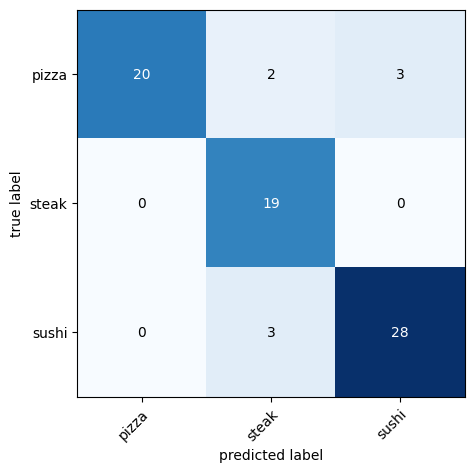

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=test_preds,
                         target=truths)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(5, 7)
)

## 4. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images.

In [ ]:
# Get all test data paths
test_samples = test_dataloader.dataset.samples

# Create a function to return a dictionary with sample, label, prediction, pre prob
def pred_and_store(samples, model, transform, device):
  list_dict = []
  for i, (path, label) in enumerate(samples):
    # Create a dictionary for one sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get label
    pred_dict["label"] = class_names[label]

    # Get predictions and prediction probabilities
    from PIL import Image
    img = Image.open(path)
    transformed_img = transform(img).unsqueeze(0)
    model.eval()
    with torch.inference_mode():
      logits = model(transformed_img.to(device))
      pred_probs = torch.softmax(logits, dim = 1).cpu()
      pred_label = torch.argmax(pred_probs, dim=1).cpu().item()

    pred_dict["pred_prob"] = pred_probs.max().cpu().item()
    pred_dict["prediction"] = class_names[pred_label]

    # Does the prediction match the label
    pred_dict["correct"] = label == pred_label

    # Append to list
    list_dict.append(pred_dict)


  return list_dict

test_pred_dicts = pred_and_store(samples=test_samples, model=model_0,
                                 transform=simple_transform, device=device)
test_pred_dicts

[{'image_path': 'data/pizza_steak_sushi/test/pizza/1152100.jpg',
  'label': 'pizza',
  'pred_prob': 0.7349491119384766,
  'prediction': 'pizza',
  'correct': True},
 {'image_path': 'data/pizza_steak_sushi/test/pizza/1503858.jpg',
  'label': 'pizza',
  'pred_prob': 0.605591893196106,
  'prediction': 'pizza',
  'correct': True},
 {'image_path': 'data/pizza_steak_sushi/test/pizza/1687143.jpg',
  'label': 'pizza',
  'pred_prob': 0.46612709760665894,
  'prediction': 'pizza',
  'correct': True},
 {'image_path': 'data/pizza_steak_sushi/test/pizza/1925494.jpg',
  'label': 'pizza',
  'pred_prob': 0.7869890928268433,
  'prediction': 'pizza',
  'correct': True},
 {'image_path': 'data/pizza_steak_sushi/test/pizza/194643.jpg',
  'label': 'pizza',
  'pred_prob': 0.40215086936950684,
  'prediction': 'pizza',
  'correct': True},
 {'image_path': 'data/pizza_steak_sushi/test/pizza/195160.jpg',
  'label': 'pizza',
  'pred_prob': 0.4827980399131775,
  'prediction': 'pizza',
  'correct': True},
 {'image_pa

In [ ]:
# Turn the test-pred-dicts into DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

,image_path,label,pred_prob,prediction,correct
70,data/pizza_steak_sushi/test/sushi/684266.jpg,sushi,0.546966,steak,False
44,data/pizza_steak_sushi/test/sushi/1172255.jpg,sushi,0.449595,steak,False
24,data/pizza_steak_sushi/test/pizza/971934.jpg,pizza,0.444701,sushi,False
12,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.435138,sushi,False
15,data/pizza_steak_sushi/test/pizza/309892.jpg,pizza,0.426874,sushi,False


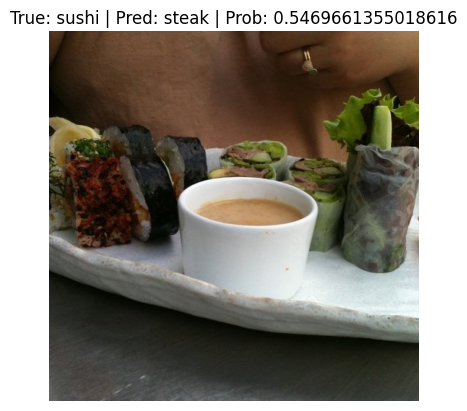

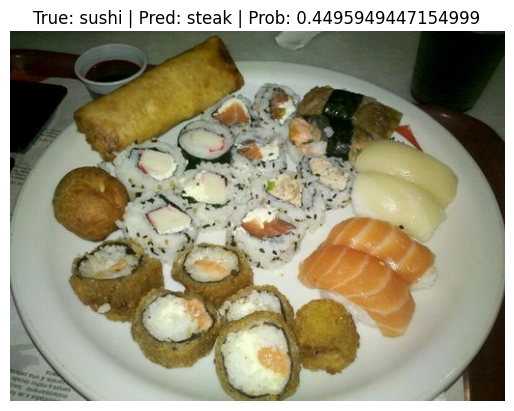

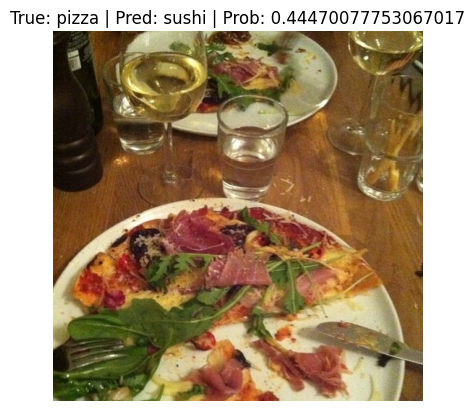

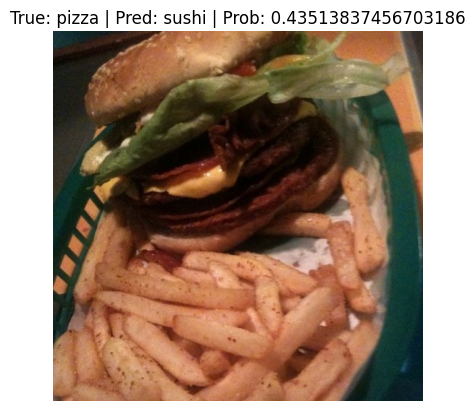

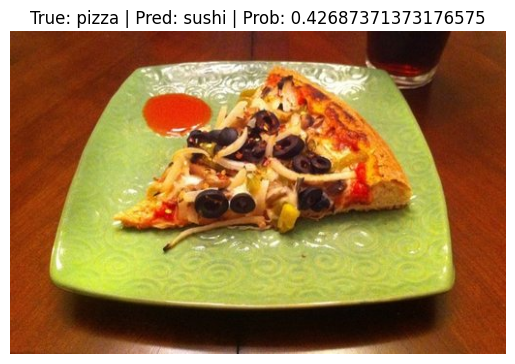

In [ ]:
# Plot the top 5 most wrong images
import matplotlib.pyplot as plt

for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row.iloc[0] # Direct access using "row[0]" is deprecated
  label = row.iloc[1]
  pred_prob = row.iloc[2]
  pred = row.iloc[3]

  # Plot the image and various details
  img = torchvision.io.read_image(str(image_path))
  plt.figure()
  plt.imshow(img.permute(1, 2, 0)) # matplotlib likes iamges in [height, width, color_channel]
  plt.title(f"True: {label} | Pred: {pred} | Prob: {pred_prob}")
  plt.axis(False)

## 5. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?

--2025-01-20 18:10:06--  https://plus.unsplash.com/premium_photo-1675451537771-0dd5b06b3985
Resolving plus.unsplash.com (plus.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to plus.unsplash.com (plus.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5232379 (5.0M) [image/jpeg]
Saving to: ‘premium_photo-1675451537771-0dd5b06b3985.1’

premium_photo-16754 100%[===================>]   4.99M  --.-KB/s    in 0.09s   

2025-01-20 18:10:06 (58.5 MB/s) - ‘premium_photo-1675451537771-0dd5b06b3985.1’ saved [5232379/5232379]



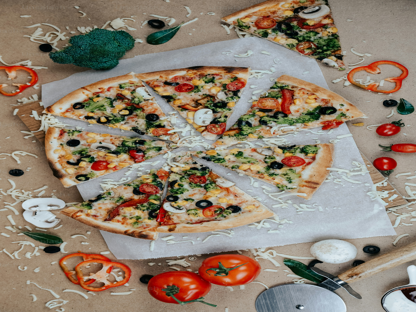

In [ ]:
# Get an image of pizza/stea/sushi
from PIL import Image
!wget https://plus.unsplash.com/premium_photo-1675451537771-0dd5b06b3985
!cp premium_photo-1675451537771-0dd5b06b3985  pizza.jpg

with Image.open("pizza.jpg") as img:
  # Reduce the image size and width by 10
  (width, height) = (img.width // 10, img.height // 20)
  img_resized = img.resize((width, height))

img_resized

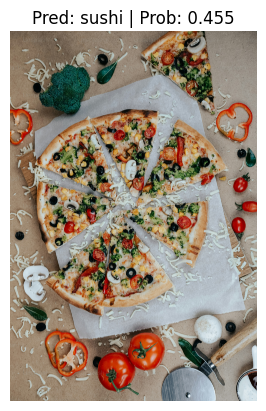

In [ ]:
# Make a function to pred and plot images
def pred_and_plot(image_path, model, transform, class_names, device=device):
  # open image
  image = Image.open(image_path)

  # transform image
  transformed_image = transform(image)

  # pred on image
  model.eval()
  with torch.inference_mode():
    pred_logit = model(transformed_image.unsqueeze(0).to(device))
    pred_prob = torch.softmax(pred_logit, dim=1)
    pred_label = torch.argmax(pred_prob, dim=1)

  # plot image and pred
  plt.figure()
  plt.imshow(image)
  plt.title(f"Pred: {class_names[pred_label]} | Prob: {pred_prob.max():.3f}")
  plt.axis(False);

pred_and_plot(image_path="pizza.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)

In [ ]:
# Get an image of steak
!wget https://plus.unsplash.com/premium_photo-1669261882830-1e504a9abf1d
!cp premium_photo-1669261882830-1e504a9abf1d steak.jpg

img = Image.open("steak.jpg")
img

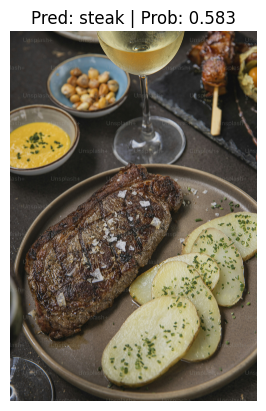

In [ ]:
pred_and_plot("steak.jpg",
              model_0,
              simple_transform,
              class_names,
              device)

In [ ]:
# Get an image of not pizza/steak/sushi
!wget https://images.unsplash.com/photo-1730177625162-66466b7adef0
!cp photo-1730177625162-66466b7adef0 random.jpg

img = Image.open("random.jpg")
img

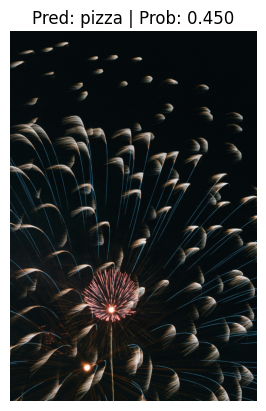

In [ ]:
pred_and_plot("random.jpg",
              model_0,
              simple_transform,
              class_names,
              device)

## 6. Train the model from section 4 in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

In [ ]:
# Recreate a new model
import torchvision
from torch import nn
model_1 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze the base layers
for param in model_1.features.parameters():
  param.requires_grad = False

# Change the classification head
torch.manual_seed(42)
model_1.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Create loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

# Setup training and save the results
model_1_results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.6022 | train_acc: 0.7656 | test_loss: 0.5565 | test_acc: 0.8864
Epoch: 7 | train_loss: 0.5411 | train_acc: 0.9258 | test_loss: 0.5279 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.5493 | train_acc: 0.8086 | test_loss: 0.5291 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.5725 | train_acc: 0.7969 | test_loss: 0.4947 | test_acc: 0.9072
Epoch: 10 | train_loss: 0.5219 | train_acc: 0.7969 | test_loss: 0.4207 | test_acc: 0.8655
[INFO] Total training time: 21.432 seconds


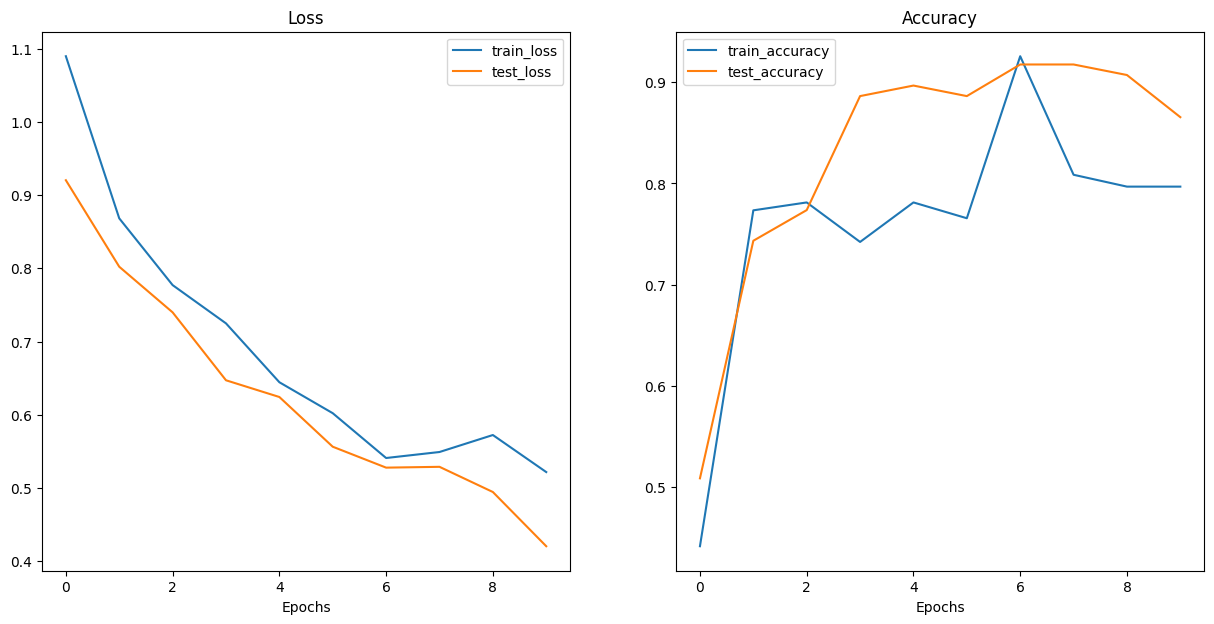

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(model_1_results)

## 7. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.

In [ ]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

data/pizza_steak_sushi_20_percent directory exists.


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e10cbceeb10>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [ ]:

# Create a new model for 20 percent of the data
model_2 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze all the base layers
for param in model_2.features.parameters():
  param.requires_grad = False

# Change the classifier head
torch.manual_seed(42)
model_2.classifier = nn.Sequential(
  nn.Dropout(p=0.2, inplace=True),
  nn.Linear(in_features=1280, out_features=3, bias=True)
).to(device)


In [ ]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_2_results = engine.train(model=model_2,
                              train_dataloader=train_dataloader_20_percent,
                              test_dataloader=test_dataloader_20_percent,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=5,
                              device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9747 | train_acc: 0.5667 | test_loss: 0.6472 | test_acc: 0.8949
Epoch: 2 | train_loss: 0.7067 | train_acc: 0.8167 | test_loss: 0.5291 | test_acc: 0.9006
Epoch: 3 | train_loss: 0.5866 | train_acc: 0.8271 | test_loss: 0.4519 | test_acc: 0.8881
Epoch: 4 | train_loss: 0.4555 | train_acc: 0.8917 | test_loss: 0.4089 | test_acc: 0.8881
Epoch: 5 | train_loss: 0.4520 | train_acc: 0.8896 | test_loss: 0.3788 | test_acc: 0.9068
[INFO] Total training time: 16.737 seconds


In [ ]:
# Check results with 10% of data for 5 epochs
max(model_0_results["test_acc"]), min(model_0_results["test_loss"])

(0.8967803030303031, 0.6243551770846049)

In [ ]:

# Check results with 20% of data for 5 epochs
max(model_2_results["test_acc"]), min(model_2_results["test_loss"])

(0.9068181818181819, 0.3788063287734985)

## 8. Try a different model from torchvision.models on the Pizza, Steak, Sushi data, how does this model perform?

In [ ]:
# Get the libs
import torch, torchvision
from torch import nn
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# get the model
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
model_3 = torchvision.models.efficientnet_b2(weights=weights)
summary(model=model_3,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
        device=device,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]  [32, 1000]         --                 True
├─Sequential (features)                                      [32, 3, 224, 224]  [32, 1408, 7, 7]   --                 True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]  [32, 32, 112, 112] --                 True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]  [32, 32, 112, 112] 864                True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] 64                 True
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --                 --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --                 True
│    │    └─M

In [ ]:
# Creating manual transform
### Gives 93% accuracy when used ### Why more than auto_transform?
manual_transfrom = transforms.Compose([
    transforms.Resize((288, 288)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])
])

In [ ]:
# Setup transform for model_2
### Gives 87% accuracy when used instead of manual transform ### Why not better?
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Get the data
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transfrom,
    batch_size=32
)
test_dataloader, train_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e10c9edb490>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# Set manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Create the classifier
model_3.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1408, out_features=len(class_names), bias=True)
).to(device)

In [ ]:

# Get optimizer and loss function
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

In [ ]:
# Freeze the feature layers
for params in model_3.features.parameters():
  params.requires_grad = False

In [ ]:

summary(model_3,
        col_names=["trainable"])

Layer (type:depth-idx)                                  Trainable
EfficientNet                                            Partial
├─Sequential: 1-1                                       False
│    └─Conv2dNormActivation: 2-1                        False
│    │    └─Conv2d: 3-1                                 False
│    │    └─BatchNorm2d: 3-2                            False
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  False
│    │    └─MBConv: 3-4                                 False
│    │    └─MBConv: 3-5                                 False
│    └─Sequential: 2-3                                  False
│    │    └─MBConv: 3-6                                 False
│    │    └─MBConv: 3-7                                 False
│    │    └─MBConv: 3-8                                 False
│    └─Sequential: 2-4                                  False
│    │    └─MBConv: 3-9                                 False
│    

In [ ]:
# Set seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer

start = timer()
# Train the model
model_3_results = engine.train(
    model=model_3,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device
)

end = timer()
print(f"[INFO] Total training time: {end-start:.3f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1073 | train_acc: 0.3555 | test_loss: 0.9175 | test_acc: 0.6619
Epoch: 2 | train_loss: 0.8770 | train_acc: 0.6719 | test_loss: 0.8638 | test_acc: 0.8248
Epoch: 3 | train_loss: 0.7917 | train_acc: 0.8008 | test_loss: 0.7738 | test_acc: 0.8153
Epoch: 4 | train_loss: 0.7213 | train_acc: 0.7812 | test_loss: 0.6499 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.6438 | train_acc: 0.8125 | test_loss: 0.6385 | test_acc: 0.8873
[INFO] Total training time: 12.624


In [ ]:
# Efficientnet_b2 | 10% data | 5 epochs
max(model_3_results["test_acc"]), min(model_3_results["test_loss"])

(0.9384469696969697, 0.6384939948717753)

In [ ]:
# Effcientnet_b0 | 20% data | 5 epochs
max(model_2_results["test_acc"]), min(model_2_results["test_loss"])

(0.9068181818181819, 0.3788063287734985)

In [ ]:
# Effcientnet_b0 | 10% data | 10 epochs
max(model_1_results["test_acc"]), min(model_1_results["test_loss"])

(0.9176136363636364, 0.4206827183564504)

In [ ]:
# Effcientnet_b0 | 10% data | 5 epochs
max(model_0_results["test_acc"]), min(model_0_results["test_loss"])

(0.8967803030303031, 0.6243551770846049)

---
THE END

